In [1]:
import itertools, json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import colors
import seaborn as sns

import sys
sys.path.append('..')
from lib import *
from lib.maxent import *
import xarray as xr

In [2]:
params = np.load('data/Human_reference_9.npz')
hi = params['hi']
Jij = params['Jij']

In [47]:
def zero_sum_gauge(J_ij):
    J_ijc = J_ij.copy()
    for i in range(Jij.shape[0]):
        J_ijc[i, i] = 0.0
    J_ij_0 = (J_ijc
              - np.mean(J_ijc, axis=2)[:, :, np.newaxis, :]
              - np.mean(J_ijc, axis=3)[:, :, :, np.newaxis]
              + np.mean(J_ijc, axis=(2,3))[:, :, np.newaxis, np.newaxis])
    return J_ij_0

In [48]:
Jij0 = zero_sum_gauge(Jij)

In [49]:
mean_Jij = Jij0.mean(axis=(0,1))

In [50]:
L = hi.shape[0]
Jij_xr = xr.DataArray(Jij0-mean_Jij,
             dims=("i", "j", 'alpha', 'beta'),
             coords={'i': range(L),
                     'j': range(L),
                     'alpha': list(aminoacids),
                     'beta':list(aminoacids)
                    })
Jij_df = Jij_xr.to_dataframe('Jij').loc[0,:].reset_index()
Jij_df.dropna(inplace=True)
Jij_df.sort_values('Jij').tail(n=10)

,j,alpha,beta,Jij
768,1,W,K,0.202598
603,1,M,E,0.204113
463,1,E,E,0.204857
1305,3,G,G,0.207567
645,1,P,G,0.207732
471,1,E,N,0.230310
1221,3,C,C,0.253613
3161,7,W,C,0.269369
2021,5,C,C,0.287882
600,1,M,A,0.316486


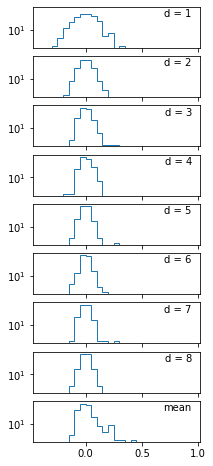

In [51]:
fig, axes = plt.subplots(figsize=(3, 8), sharex=True, sharey=True, nrows=L)
for j in range(1, L):
    ax = axes[j-1]
    ax.hist(Jij_df[Jij_df['j']==j]['Jij'], bins=np.arange(-0.4, 1.0, 0.05), histtype='step')
    ax.text(0.95, 0.95, 'd = %i'%j, transform=ax.transAxes, va='top', ha='right')
ax = axes[-1]
ax.hist(mean_Jij.flatten(), bins=np.arange(-0.4, 1.0, 0.05), histtype='step')
ax.text(0.95, 0.95, 'mean', transform=ax.transAxes, va='top', ha='right')
for ax in axes:
    ax.set_yscale('log')

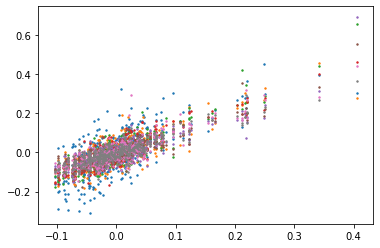

In [53]:
for j in range(1, 9):
    plt.scatter(mean_Jij, Jij0[0, j], s=2)

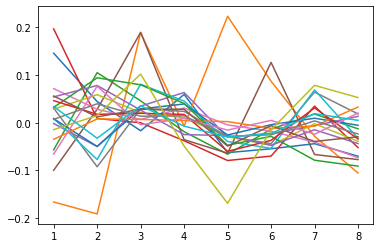

In [54]:
dist = np.arange(1, 9)
for i in range(naminoacids):
    plt.plot(dist, Jij0[0, dist][:,i,i]-np.mean(Jij0[0, dist][:,i,i]))

In [55]:
symmetrized = np.zeros_like(mean_Jij)
for i in range(naminoacids):
    for j in range(naminoacids):
        symmetrized[i, j] = 0.5*(mean_Jij[i, j] + mean_Jij[j, i])

In [56]:
def label(ax, aminoacidorder):
    ax.set_xticks(range(naminoacids))
    ax.set_yticks(range(naminoacids))
    ax.set_xticklabels(list(aminoacidorder))
    ax.set_yticklabels(list(aminoacidorder))

In [57]:
aminoacids_coucke = 'ACFILMVWYPHKRDENQSTG'

In [58]:
indices = [aminoacids.index(aa) for aa in aminoacids_coucke]

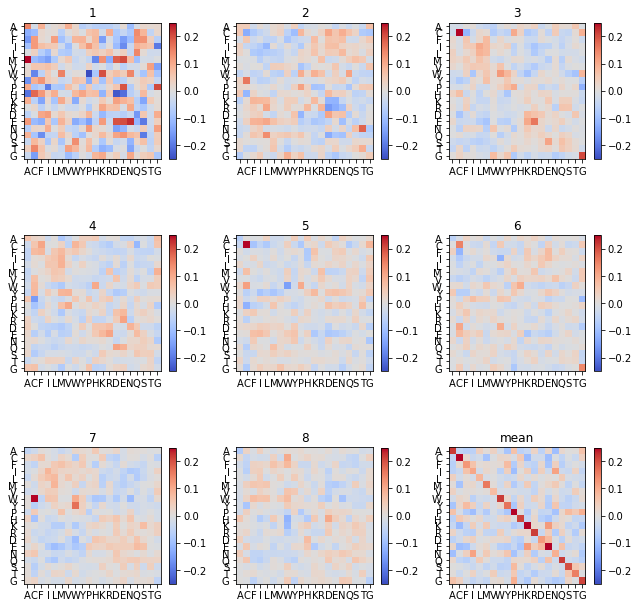

In [80]:
imshow_kwargs = dict(vmin=-0.25, vmax=0.25, cmap='coolwarm')
fig, axes_arr = plt.subplots(figsize=(9, 9), nrows=3, ncols=3)
axes = axes_arr.flatten()
for j in range(1, 9):
    ax = axes[j-1]
    im = ax.imshow((Jij0[0,j]-mean_Jij)[indices, :][:, indices], **imshow_kwargs)
    ax.set_title(j)
    label(ax, aminoacids_coucke)
    fig.colorbar(im, ax=ax, shrink=0.7)
ax = axes[-1]
im = ax.imshow(mean_Jij[indices, :][:, indices], **imshow_kwargs)
ax.set_title('mean')
label(ax, aminoacids_coucke)
fig.colorbar(im, ax=ax, shrink=0.7)
fig.tight_layout()

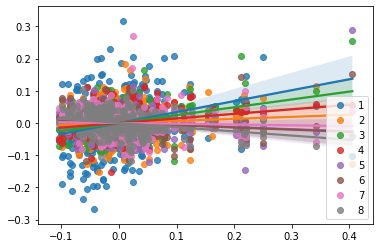

In [60]:
for j in range(1, L):
    sns.regplot(mean_Jij.flatten(), (Jij0[0,j]-mean_Jij).flatten(), label=j)
plt.legend()

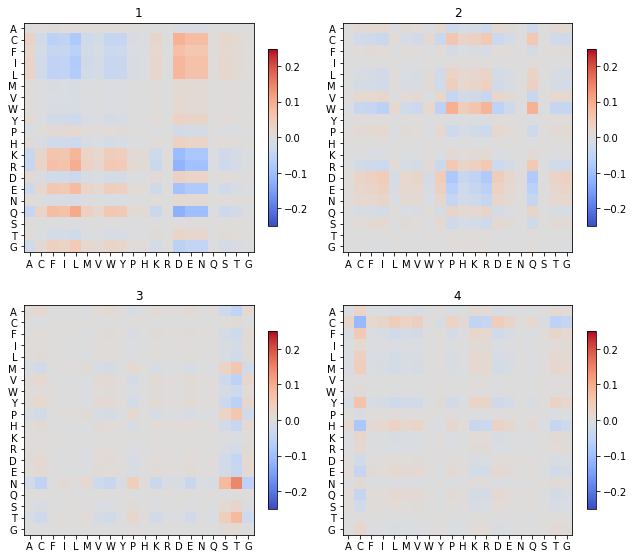

In [61]:
fig, axes_arr = plt.subplots(figsize=(9, 8), nrows=2, ncols=2)
axes = axes_arr.flatten()
U, s, Vh = scipy.linalg.svd(Jij0[0, 2]-mean_Jij)
for i in range(4):
    im = axes[i].imshow((s[i]*np.outer(U.T[i], Vh[i]))[indices, :][:, indices], **imshow_kwargs)
    axes[i].set_title(i+1)
    label(axes[i], aminoacids_coucke)
    fig.colorbar(im, ax=axes[i], shrink=0.7)
fig.tight_layout()

In [17]:
w, v = scipy.linalg.eigh(symmetrized)

(array([0., 0., 1., 1., 3., 2., 4., 2., 1., 1., 1., 1., 0., 1., 0., 0., 0.,
        0., 1., 1., 0.]),
 array([-2.00000000e-01, -1.50000000e-01, -1.00000000e-01, -5.00000000e-02,
        -5.55111512e-17,  5.00000000e-02,  1.00000000e-01,  1.50000000e-01,
         2.00000000e-01,  2.50000000e-01,  3.00000000e-01,  3.50000000e-01,
         4.00000000e-01,  4.50000000e-01,  5.00000000e-01,  5.50000000e-01,
         6.00000000e-01,  6.50000000e-01,  7.00000000e-01,  7.50000000e-01,
         8.00000000e-01,  8.50000000e-01]),
 <a list of 21 Patch objects>)

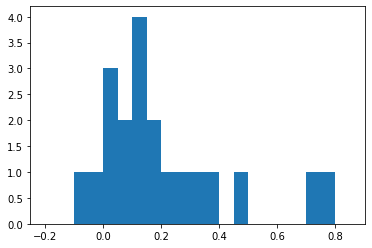

In [18]:
plt.hist(w, bins=np.arange(-0.2, 0.9, 0.05))

In [19]:
arr = np.load('../aafreqpca/data/data.npz')
aa_human = arr['human']

In [20]:
cov = np.cov(aa_human.T)

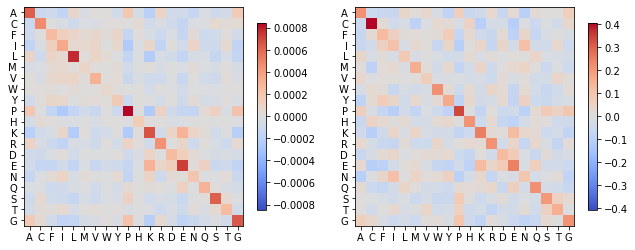

In [40]:
fig, axes = plt.subplots(figsize=(9, 4), ncols=2)
for i, matrix in enumerate([cov, mean_Jij]):
    ax = axes[i]
    im = ax.imshow(matrix[indices, :][:, indices], vmin=-matrix.max(), vmax=matrix.max(), cmap='coolwarm')
    label(ax, aminoacids_coucke)
    fig.colorbar(im, ax=ax, shrink=0.7)
fig.tight_layout()